Feature ranking and automatic feature selection
-----------------------------------------------

This notebook generates multiple feature importance scores, ranks the features
and automatically suggests a feature selection based on the majority vote of all models.

The following six models for feature importance scoring are included:
- Spearman rank analysis (see 'selectio.models.spearman')
- Correlation coefficient significance of linear/log-scaled Bayesian Linear Regression (see 'selectio.models.blr')
- Random Forest Permutation test (see 'selectio.models.rf.py')
- Random Decision Trees on various subsamples of data (see 'selectio.models.rdt.py')
- Mutual Information Regression (see 'selectio.models.mi')
- General correlation coefficients (see 'selectio.models.xicor')

This notebook generate synthetic test data but can be used with any tabulated data or dataframes.

User settings, such as input/output paths and all other options, are set in the settings file 
(Default filename: settings_featureimportance.yaml) 
Alternatively, the settings file can be specified as a command line argument with: 
'-s', or '--settings' followed by PATH-TO-FILE/FILENAME.yaml 
(e.g. python featureimportance.py -s settings_featureimportance.yaml).

Requirements:
- selectio
- matplotlib
- pyyaml
- pandas

This package is part of the machine learning project developed for the Agricultural Research Federation (AgReFed).



In [1]:
# Import libraries
import os 
import yaml
import shutil
import numpy as np
import pandas as pd
import importlib
import pkg_resources
import matplotlib.pyplot as plt
from matplotlib.image import imread
# Import selection package
from selectio import selectio
from selectio.simdata import create_simulated_features
from selectio.utils import plot_correlationbar, plot_feature_correlation_spearman, gradientbars

### Define output directory

In [2]:
# Generate result folder and name of settings file to save configuration
outpath = 'results_featureselection_moisture_2021weekly'
os.makedirs(outpath, exist_ok = True)
fname_settings = 'settings_featureimportance_moisture.yaml'

### Reading data

In [3]:
 # This function generates simulated data with added noise 
 # and automatically saves data and coefficients in output directory as csv files
 inpath = "../../../data/Llara/bars/rescaled_csv/"
 df = pd.read_csv(os.path.join(inpath,"Soilmoisture_all_covariates_weekly_2021.csv"))

feature_names = [
  'DEM',
  'AVERAGE-Air-Temperature',
  'TOTAL-Rain-Gauge',
  'AVERAGE-Soil-Temp-10cm',
  'AVERAGE-Soil-Temp-30cm',
  'AVERAGE-Soil-Temp-50cm',
  's2_barest_earth_channel0_mean',
  's2_barest_earth_channel1_mean',
  's2_barest_earth_channel2_mean',
  'Landscape_Prescott_index',
  'Landscape_Slope_median_300m',
  'Landscape_Relief_300m',
  'Landscape_Slope',
  'Landscape_Topographic_wetness_index',
  'Landscape_MrVBF',
  'Landscape_Profile_curvature',
  'radmap2019_grid_dose']




# print generated dataframe header 
print('')
print('Dataframe header extract: ')
df.head()


Dataframe header extract: 


,week,EASTING,NORTHING,Probe_SenA,JD,D1,D2,D3,D4,D5,...,Landscape_Prescott_index,Landscape_Slope,Landscape_Slope_median_300m,Landscape_Relief_300m,Landscape_Topographic_wetness_index,Landscape_MrVBF,Landscape_Profile_curvature,radmap2019_grid_dose,year,month
0,0,654570.185,6184730.714,174.0,2459216.5,0.169199,0.186912,0.197273,0.186665,0.194856,...,0.697788,2.435062,2.732849,19.008759,10.746004,3.0,0.000171,59.518517,2021.0,1.0
1,0,654770.286,6184746.625,177.0,2459216.5,0.132025,0.165270,0.200996,0.212356,0.233829,...,0.700408,1.769090,2.759444,16.096893,11.577003,3.0,-0.000281,60.869484,2021.0,1.0
2,0,654789.753,6184478.390,155.0,2459216.5,0.180442,0.139751,0.127021,0.134822,0.135326,...,0.694724,2.789172,2.356629,14.036926,8.396977,0.0,0.000162,61.228860,2021.0,1.0
3,0,654993.631,6184713.018,139.0,2459216.5,0.127213,0.130043,0.143134,0.165427,0.187791,...,0.706158,4.183993,2.618401,15.216522,8.295820,3.0,-0.000015,61.983750,2021.0,1.0
4,0,655039.504,6183614.227,175.0,2459216.5,0.101303,0.100311,0.101152,0.104682,0.114581,...,0.715732,7.434627,7.186032,35.359040,8.739443,0.0,0.000260,62.897920,2021.0,1.0


### A) Generate Settings YAML file

In [4]:
# define settings name
# generate settings template
shutil.copyfile(selectio._fname_settings, os.path.join(outpath, fname_settings))
with open(os.path.join(outpath, fname_settings), 'r') as f:
    settings = yaml.load(f, Loader=yaml.FullLoader)
settings['name_features'] = feature_names
settings['name_target'] = 'D1'
settings['infname'] = "Soilmoisture_all_covariates_weekly_2021.csv"
settings['inpath'] = inpath
settings['outpath'] = outpath
settings_path = os.path.join(outpath, fname_settings)
print('Saving settings in: ', settings_path)
with open(settings_path, 'w') as f:
    yaml.dump(settings, f)

print('Settings:')
[print(f'{keys}: {values}') for keys, values in settings.items()]

Saving settings in:  results_featureselection_moisture_2021weekly/settings_featureimportance_moisture.yaml
Settings:
inpath: ../../../data/Llara/bars/rescaled_csv/
infname: Soilmoisture_all_covariates_weekly_2021.csv
outpath: results_featureselection_moisture_2021weekly
name_target: D1
name_features: ['DEM', 'AVERAGE-Air-Temperature', 'TOTAL-Rain-Gauge', 'AVERAGE-Soil-Temp-10cm', 'AVERAGE-Soil-Temp-30cm', 'AVERAGE-Soil-Temp-50cm', 's2_barest_earth_channel0_mean', 's2_barest_earth_channel1_mean', 's2_barest_earth_channel2_mean', 'Landscape_Prescott_index', 'Landscape_Slope_median_300m', 'Landscape_Relief_300m', 'Landscape_Slope', 'Landscape_Topographic_wetness_index', 'Landscape_MrVBF', 'Landscape_Profile_curvature', 'radmap2019_grid_dose']


[None, None, None, None, None]

### B) Run automatic feature selection and plotting

In [5]:
# Run selectio main 
selectio.main(settings_path)

Calculate Spearman correlation matrix...
Computing scores for model spearman...
Done, 14 features selected.
Computing scores for model mi...
Done, 16 features selected.
Computing scores for model xicor...
Done, 16 features selected.
Computing scores for model blr...
Done, 5 features selected.
Computing scores for model rf...
Done, 12 features selected.
Computing scores for model rdt...
Done, 16 features selected.
Feature selection: 
                          name_features  score_combined
3                AVERAGE-Soil-Temp-10cm          0.1616
1               AVERAGE-Air-Temperature          0.1456
4                AVERAGE-Soil-Temp-30cm          0.1019
2                      TOTAL-Rain-Gauge          0.0654
14                      Landscape_MrVBF          0.0609
13  Landscape_Topographic_wetness_index          0.0575
15          Landscape_Profile_curvature          0.0533
10          Landscape_Slope_median_300m          0.0486
7         s2_barest_earth_channel1_mean          0.0458
12 

### C) Read dataframe of computed feature importance scores

In [6]:
dfresults = pd.read_csv(os.path.join(outpath,'feature-importance_scores.csv'), index_col='Feature_index')
dfresults

,name_features,score_spearman,score_mi,score_xicor,score_blr,score_rf,score_rdt,woe_spearman,woe_mi,woe_xicor,woe_blr,woe_rf,woe_rdt,score_combined,selected
Feature_index,,,,,,,,,,,,,,,
0,DEM,0.0421,0.0794,0.0693,0.0000,0.0111,0.0330,1,1,1,0,1,1,0.0394,1
1,AVERAGE-Air-Temperature,0.1359,0.0325,0.0858,0.0000,0.4544,0.1607,1,1,1,0,1,1,0.1456,1
2,TOTAL-Rain-Gauge,0.0415,0.0168,0.0751,0.1159,0.0760,0.0648,1,1,1,1,1,1,0.0654,1
3,AVERAGE-Soil-Temp-10cm,0.1455,0.0370,0.0867,0.4533,0.0794,0.1627,1,1,1,1,1,1,0.1616,1
4,AVERAGE-Soil-Temp-30cm,0.1542,0.0411,0.0842,0.0000,0.1188,0.2101,1,1,1,0,1,1,0.1019,1
5,AVERAGE-Soil-Temp-50cm,0.0489,0.0037,0.0000,0.0000,0.0000,0.0090,1,0,0,0,0,0,0.0082,0
6,s2_barest_earth_channel0_mean,0.0000,0.0825,0.0546,0.0000,0.0258,0.0417,0,1,1,0,1,1,0.0343,1
7,s2_barest_earth_channel1_mean,0.0000,0.0762,0.0607,0.0930,0.0137,0.0299,0,1,1,1,1,1,0.0458,1
8,s2_barest_earth_channel2_mean,0.0000,0.0768,0.0452,0.0000,0.0063,0.0234,0,1,1,0,0,1,0.0244,1


In [7]:
# Show selected features only
dfresults[dfresults.selected == 1].sort_values('score_combined', ascending=False)

,name_features,score_spearman,score_mi,score_xicor,score_blr,score_rf,score_rdt,woe_spearman,woe_mi,woe_xicor,woe_blr,woe_rf,woe_rdt,score_combined,selected
Feature_index,,,,,,,,,,,,,,,
3,AVERAGE-Soil-Temp-10cm,0.1455,0.0370,0.0867,0.4533,0.0794,0.1627,1,1,1,1,1,1,0.1616,1
1,AVERAGE-Air-Temperature,0.1359,0.0325,0.0858,0.0000,0.4544,0.1607,1,1,1,0,1,1,0.1456,1
4,AVERAGE-Soil-Temp-30cm,0.1542,0.0411,0.0842,0.0000,0.1188,0.2101,1,1,1,0,1,1,0.1019,1
2,TOTAL-Rain-Gauge,0.0415,0.0168,0.0751,0.1159,0.0760,0.0648,1,1,1,1,1,1,0.0654,1
14,Landscape_MrVBF,0.0781,0.0157,0.0158,0.2197,0.0000,0.0343,1,1,1,1,0,1,0.0609,1
13,Landscape_Topographic_wetness_index,0.0653,0.0825,0.0712,0.0000,0.0850,0.0394,1,1,1,0,1,1,0.0575,1
15,Landscape_Profile_curvature,0.0448,0.0831,0.0540,0.1181,0.0058,0.0184,1,1,1,1,0,1,0.0533,1
10,Landscape_Slope_median_300m,0.0720,0.0723,0.0712,0.0000,0.0311,0.0434,1,1,1,0,1,1,0.0486,1
7,s2_barest_earth_channel1_mean,0.0000,0.0762,0.0607,0.0930,0.0137,0.0299,0,1,1,1,1,1,0.0458,1


## Show all output images

In [8]:
# Get all filenames with  .png format from output directory
files = os.listdir(outpath)
pngfiles = [name for name in files if name.endswith('.png')]
print('Image files generated: ', pngfiles)

Image files generated:  ['Models-feature-importances.png', 'Feature_Correlations_Hierarchical_Spearman.png', 'Combined-feature-importance.png']


### Feature Correlation Cluster

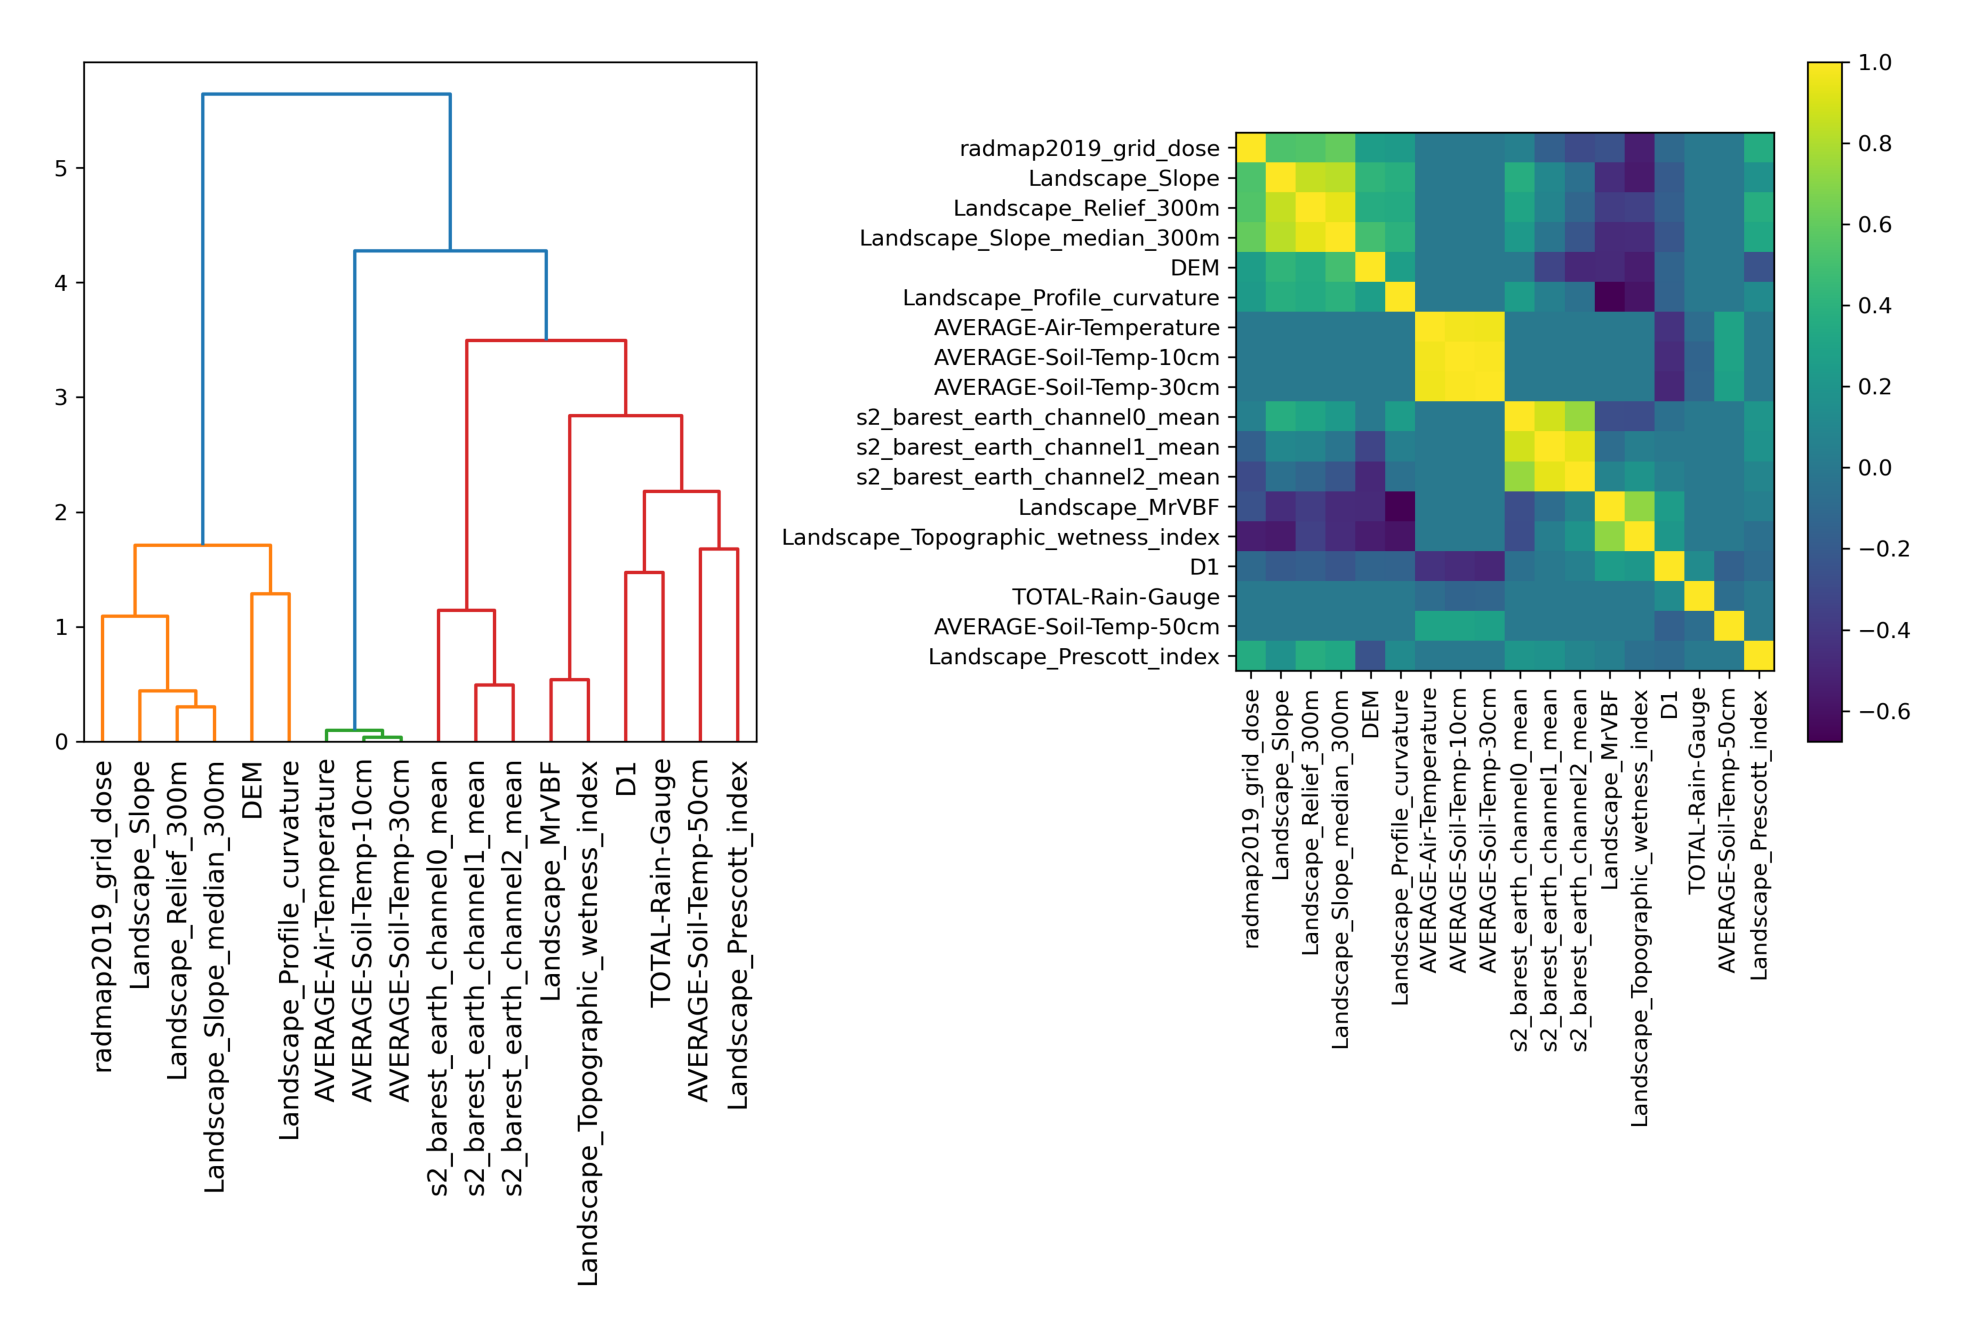

In [9]:
filename = 'Feature_Correlations_Hierarchical_Spearman.png'
img = imread(f"{outpath}/{filename}", format='PNG')
fig = plt.figure(dpi=300)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
plt.imshow(img)

### Model Importance Scores

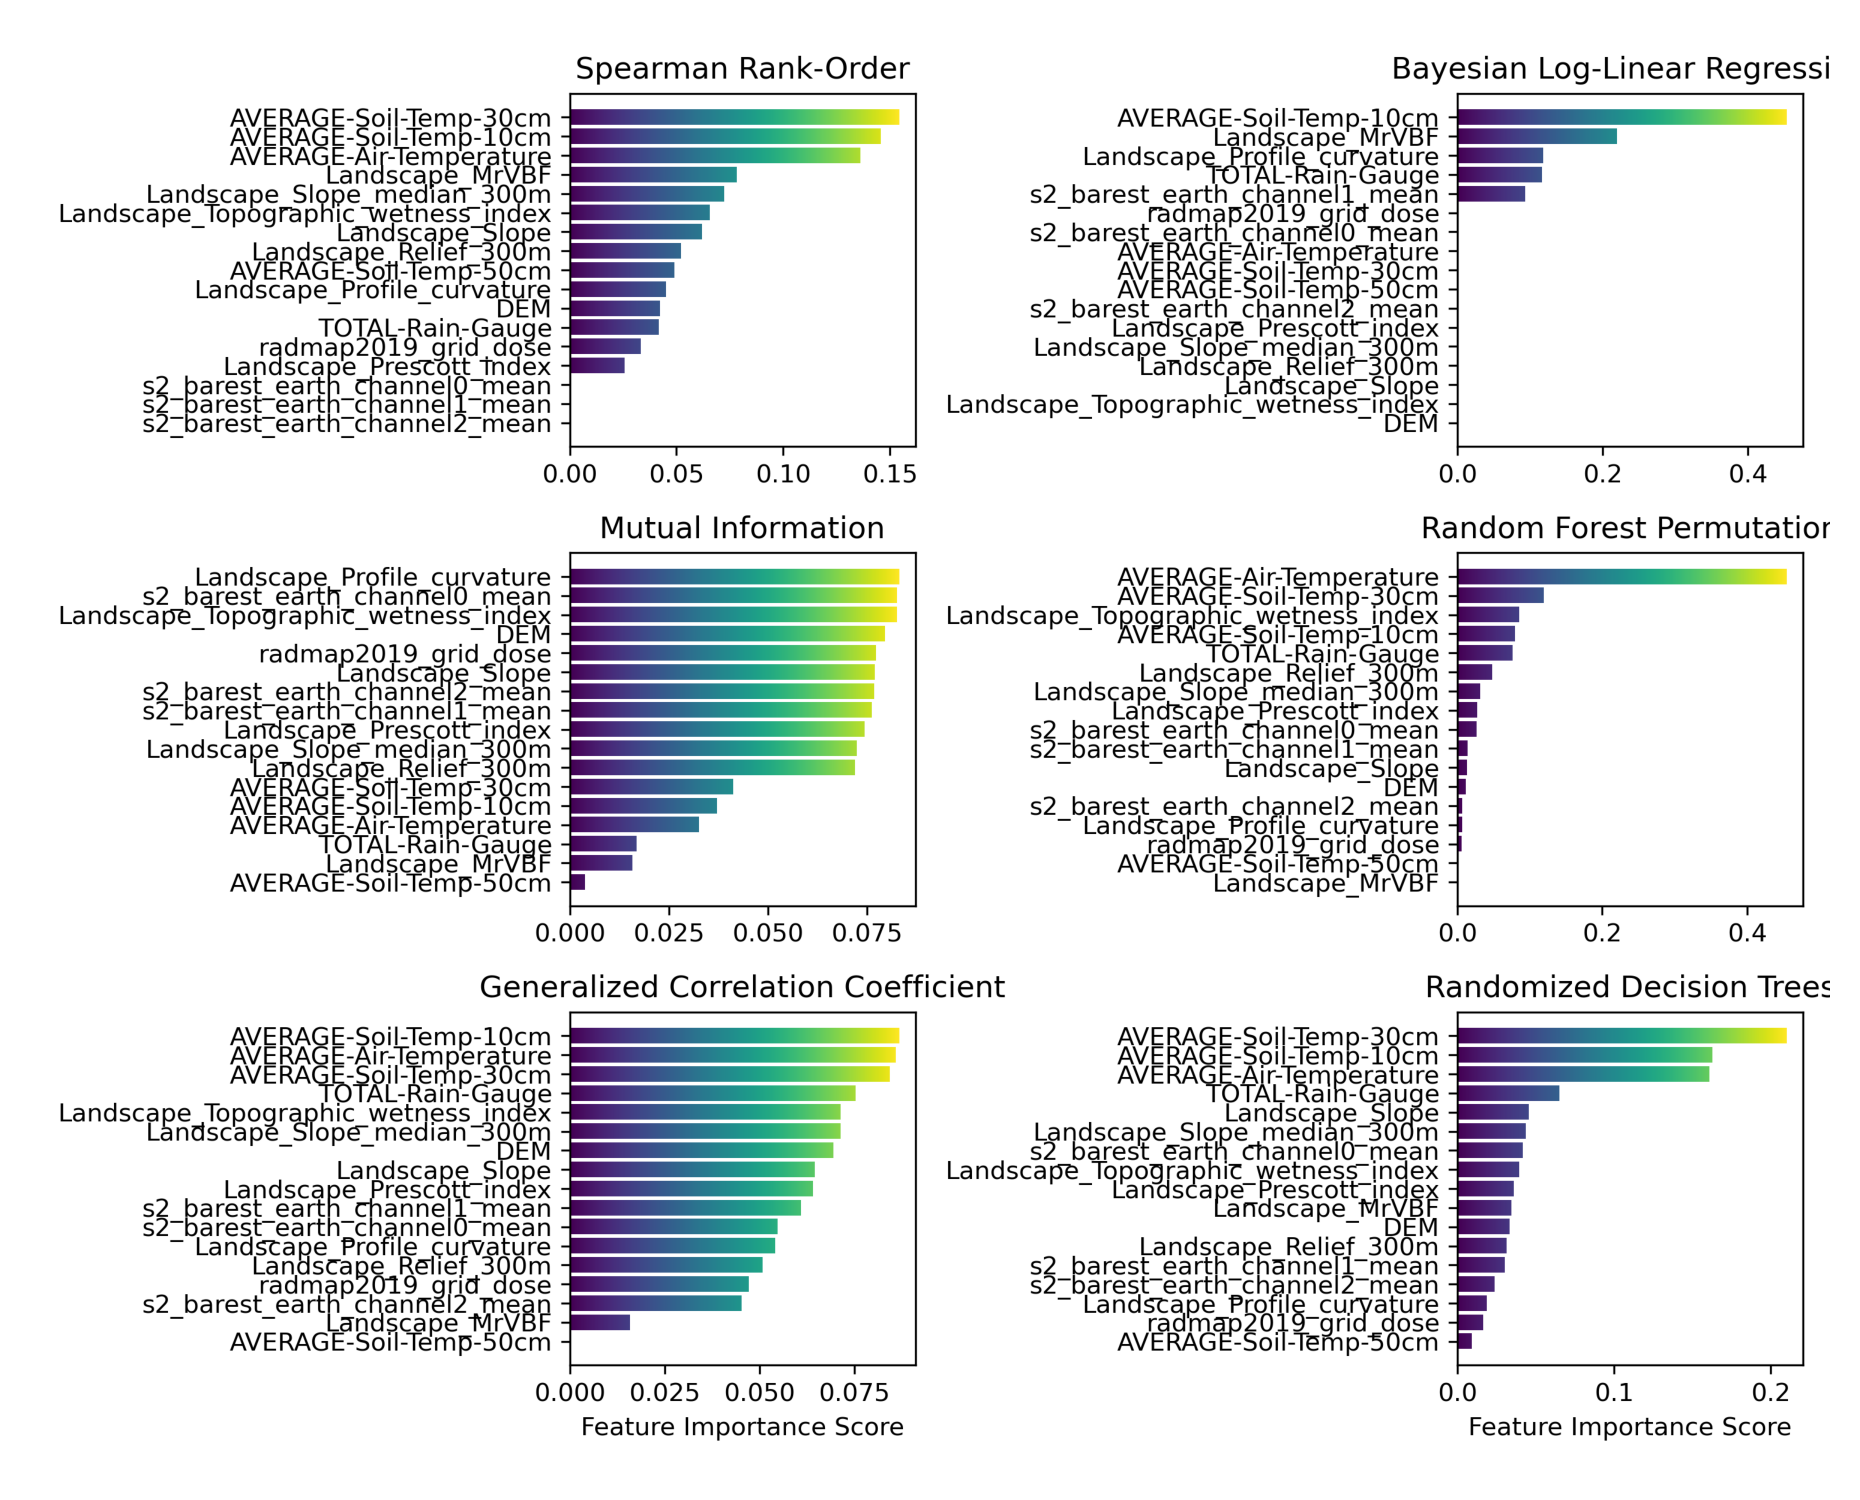

In [10]:
filename = 'Models-feature-importances.png'
img = imread(f"{outpath}/{filename}", format='PNG')
fig = plt.figure(dpi=300)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
plt.imshow(img)

### Combined Model Importance Scores

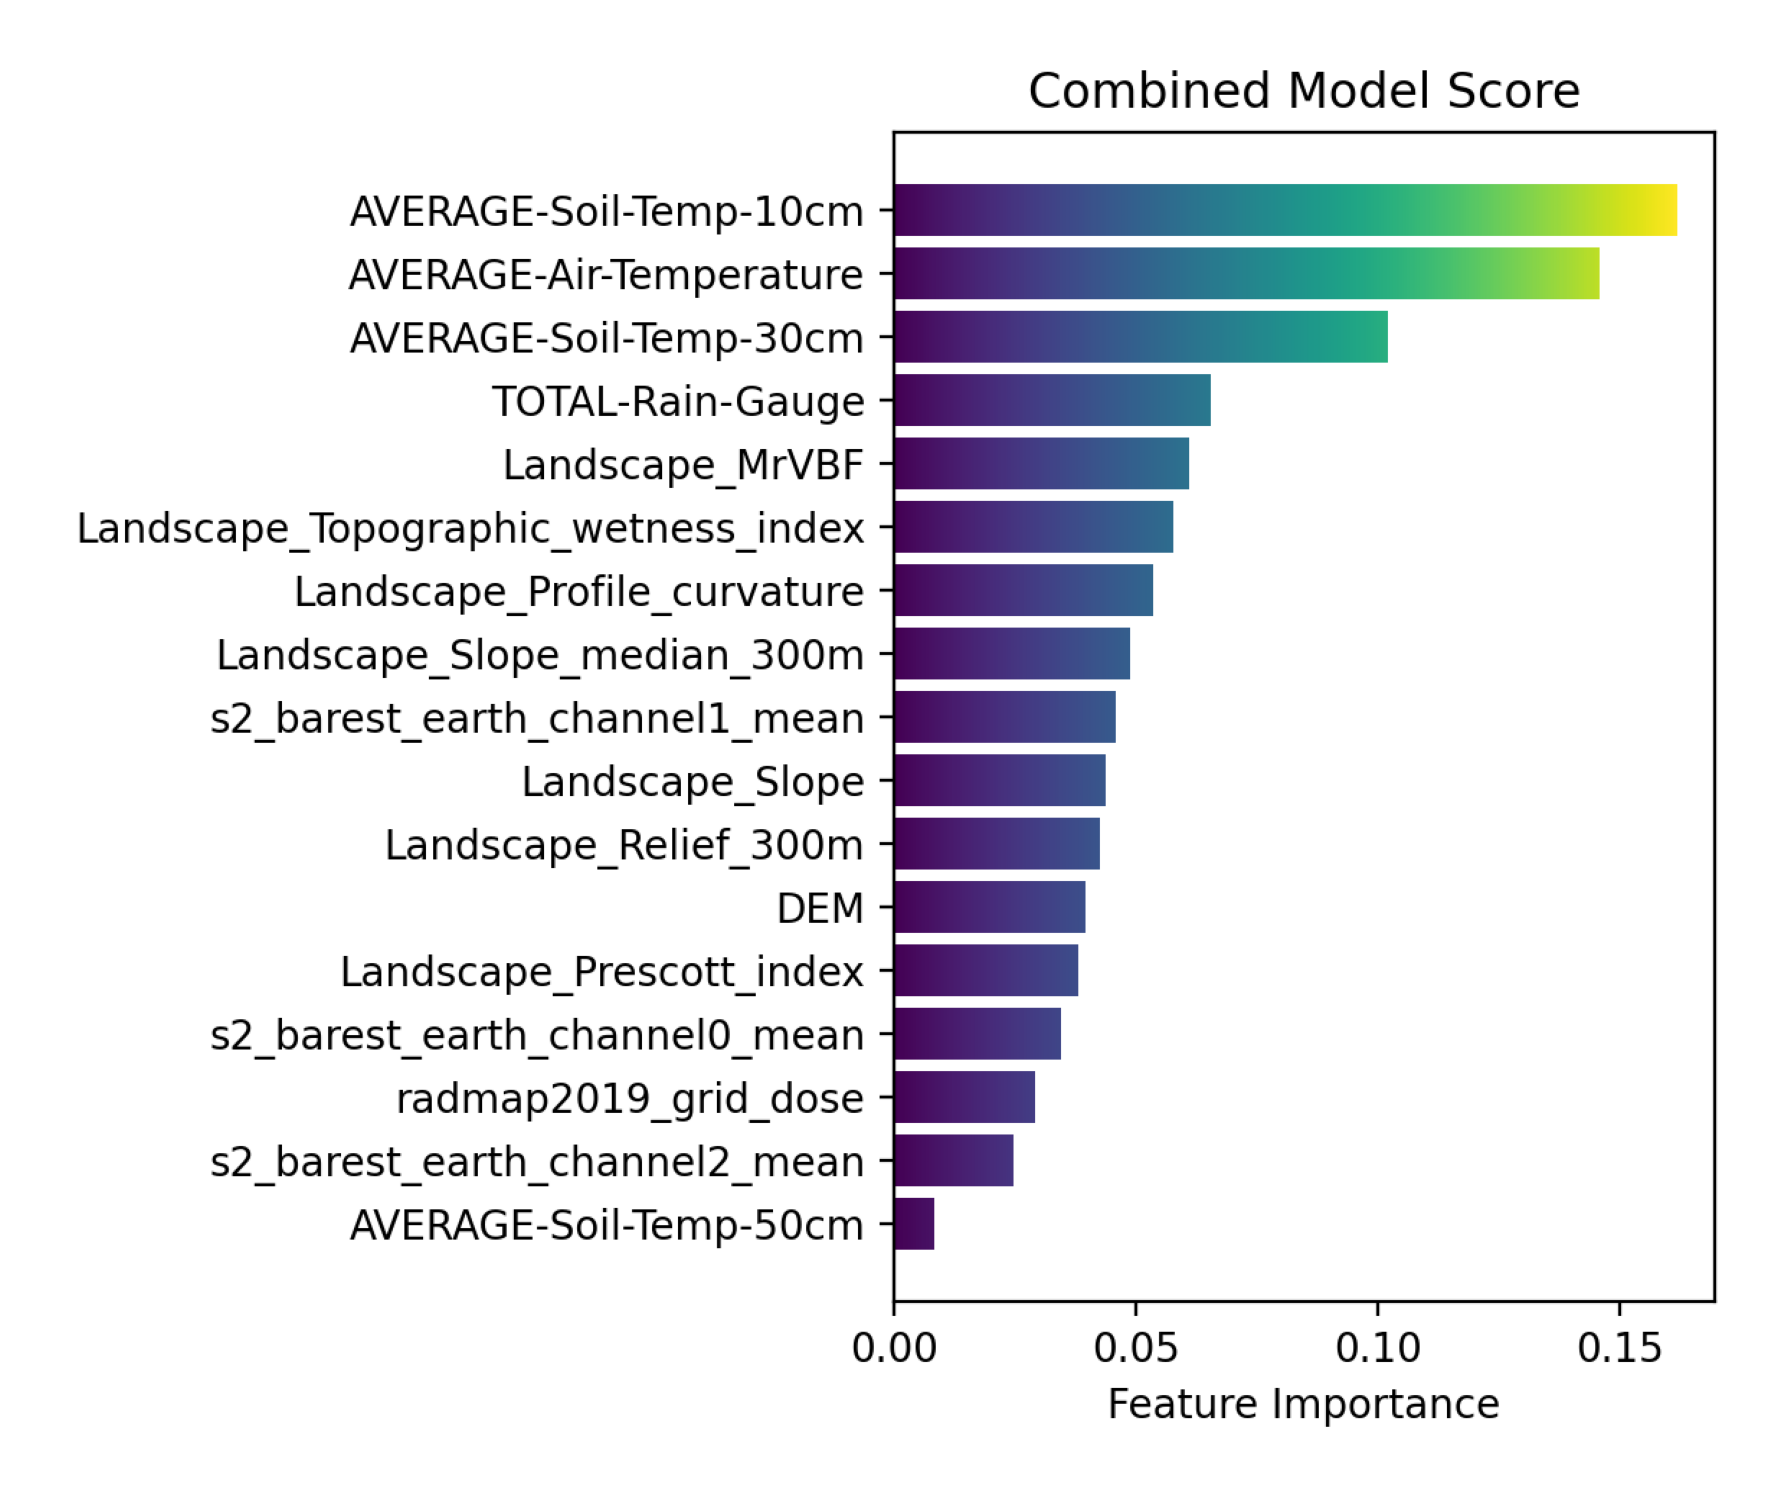

In [11]:
filename = 'Combined-feature-importance.png'
img = imread(f"{outpath}/{filename}", format='PNG')
fig = plt.figure(dpi=300)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
plt.imshow(img)

## Result Notes

- most impactful factor: Soil Temperature at 10cm
- Soil temperatures and air temperatures are strongly correlated (see Spearman Feature Correlation Cluster)
- From the 3 Sentinel bands (RGB), the strongest factor is channel 1 (most channel are correlated):
- Suggestion for final feature selection: all factors with combined score > 0.05; select strongest feature from correlated feature cluster.
- Final selection: "AVERAGE-Soil-Temp-10cm", "s2_barest_earth_channel1_mean", "Landscape_Topographic_wetness_index",  "TOTAL-Rain-Gauge", "Landscape_Slope_median_300m", "Landscape_MrVBF", "DEM"